<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/5-ImageClass/ArchitecturesAdv/architec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/5-ImageClass/ArchitecturesAdv/architec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Githubdan data indir

Bu dataset kaggledan alınmış FER 2013 challenge datasıdır.  modelleri zorladığı için kullanması keyifli

https://www.kaggle.com/datasets/msambare/fer2013?resource=download

In [19]:
!wget https://github.com/onuralpArsln/MlAiTutorialProjects/raw/main/5-ImageClass/Fer2013Kaggle.zip -q -O data.zip

In [20]:
!unzip -q data.zip

replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [21]:
!pip -q install visualkeras

Python ile hızlıca datayı eğitim için hazırla

In [22]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, models


# 📂 Dataset ana klasörleri
test_dir = 'test'   # test/angry, test/disgust, test/fear ...
train_dir = 'train' # train/angry, train/disgust, train/fear ...

# 📌 Görselleri yükleyen fonksiyon (48x48 dataset için)
def load_images_from_directory(base_dir, label, img_size=(48, 48), limit=90000):
    images = []
    labels = []
    count = 0
    for file_name in os.listdir(base_dir):
        if count >= limit:  # 300'den sonra dur
            break
        if file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            file_path = os.path.join(base_dir, file_name)
            # grayscale yaptık çünkü kaynak grayscale
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=img_size, color_mode="grayscale")
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # normalize
            images.append(img_array)
            labels.append(label)
            count += 1
    return images, labels

# Duygu klasörleri ve etiketleri
emotion_dirs = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "surprise": 5,
    "sad": 6
}

# --- Train verisi ---
train_images, train_labels = [], []
for emotion, label in emotion_dirs.items():
    img_dir = os.path.join(train_dir, emotion)
    images, labels = load_images_from_directory(img_dir, label=label)
    train_images.extend(images)
    train_labels.extend(labels)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# --- Test verisi ---
test_images, test_labels = [], []
for emotion, label in emotion_dirs.items():
    img_dir = os.path.join(test_dir, emotion)
    images, labels = load_images_from_directory(img_dir, label=label)
    test_images.extend(images)
    test_labels.extend(labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)


X_train, y_train = train_images, train_labels
X_test, y_test = test_images, test_labels


In [23]:
print("Elindeki veri miktarı ve test train dağlımı")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Elindeki veri miktarı ve test train dağlımı
X_train shape: (28709, 48, 48, 1)
X_test shape: (7178, 48, 48, 1)
y_train shape: (28709,)
y_test shape: (7178,)
Train samples: 28709
Test samples: 7178


Helper Functions

In [24]:
import time
from tensorflow.keras.utils import plot_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def compile_and_train(model, name, epochs=5, batch_size=64):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    start = time.time()
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)
    end = time.time()
    plot_model(model, to_file=f"{name}.png", show_shapes=True, dpi=80)
    print(f"{name} trained in {(end-start):.2f}s")
    return model, history

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(tf.TensorSpec([1,*model.input.shape[1:]]))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph.as_graph_def()
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops


### CNN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,279 (4.36 MB)

 Trainable params: 1,142,279 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


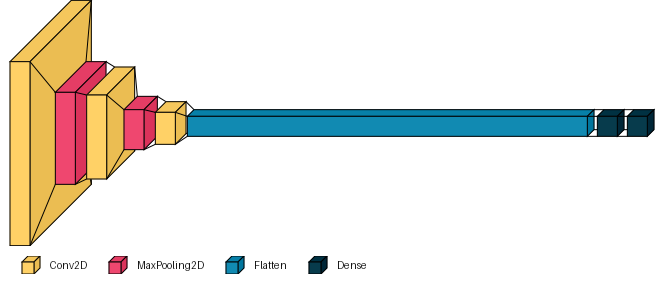

In [25]:
def build_cnn(input_shape=(48,48,1), num_classes=7):
    return models.Sequential([
        layers.Conv2D(32,3,activation='relu',input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128,3,activation='relu'),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(num_classes,activation='softmax')
    ])

cnn_model = build_cnn()

# Summary
cnn_model.summary()
tf.keras.utils.plot_model(cnn_model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Plot model architecture
tf.keras.utils.plot_model(
    cnn_model, to_file="cnn_model.png",
    show_shapes=True, show_layer_names=True, dpi=80
)

import visualkeras
from PIL import ImageFont
visualkeras.layered_view(cnn_model, legend=True, to_file="cnn_visual.png")




In [ ]:
# train
cnn, hist_cnn = compile_and_train(build_cnn(), "CNN")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
229/449 ━━━━━━━━━━━━━━━━━━━━ 1:08 312ms/step - accuracy: 0.2668 - loss: 1.8025

### ResNet

In [ ]:
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters,3,padding='same',strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters,3,padding='same')(x)
    x = layers.BatchNormalization()(x)
    if stride!=1 or shortcut.shape[-1]!=filters:
        shortcut = layers.Conv2D(filters,1,strides=stride,padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.add([x,shortcut])
    return layers.ReLU()(x)

def build_resnet(input_shape=(48,48,1), num_classes=7):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(inp)
    x = residual_block(x,32)
    x = residual_block(x,64,stride=2)
    x = residual_block(x,128,stride=2)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_classes,activation='softmax')(x)
    return models.Model(inp,out)

resnet_model = build_resnet()

# Summary
resnet_model.summary()

# Keras plot
tf.keras.utils.plot_model(resnet_model, to_file="resnet_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(resnet_model, legend=True, to_file="resnet_visual.png")


In [ ]:
# train
resnet, hist_resnet = compile_and_train(resnet_model, "ResNet")


### DenseNet

In [ ]:
from tensorflow.keras.applications import DenseNet121

def build_densenet(input_shape=(48,48,1), num_classes=7):
    base = DenseNet121(weights=None, include_top=False, input_shape=input_shape)
    x = layers.GlobalAveragePooling2D()(base.output)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(base.input, out)

densenet_model = build_densenet()

# Summary
densenet_model.summary()

# Keras plot
tf.keras.utils.plot_model(densenet_model, to_file="densenet_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(densenet_model, legend=True, to_file="densenet_visual.png")


In [ ]:
densenet, hist_densenet = compile_and_train(densenet_model, "DenseNet")


### EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet(input_shape=(48,48,1), num_classes=7):
    base = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
    x = layers.GlobalAveragePooling2D()(base.output)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(base.input, out)

efficientnet_model = build_efficientnet()

# Summary
efficientnet_model.summary()

# Keras plot
tf.keras.utils.plot_model(efficientnet_model, to_file="efficientnet_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(efficientnet_model, legend=True, to_file="efficientnet_visual.png")


In [ ]:
# train
efficientnet, hist_eff = compile_and_train(efficientnet_model, "EfficientNet")


### CNN + SE (Attention)

In [ ]:
def se_block(x, ratio=8):
    f = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(f//ratio,activation='relu')(se)
    se = layers.Dense(f,activation='sigmoid')(se)
    se = layers.Reshape((1,1,f))(se)
    return layers.multiply([x,se])

def build_cnn_se(input_shape=(48,48,1), num_classes=7):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = se_block(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = se_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_classes,activation='softmax')(x)
    return models.Model(inp,out)

cnn_se_model = build_cnn_se()

# Summary
cnn_se_model.summary()

# Keras plot
tf.keras.utils.plot_model(cnn_se_model, to_file="cnn_se_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(cnn_se_model, legend=True, to_file="cnn_se_visual.png")


In [ ]:
# Train
cnn_se, hist_se = compile_and_train(cnn_se_model, "CNN-SE")


### Vision Transformer

In [ ]:
def build_vit(input_shape=(48,48,1), num_classes=7,
              patch_size=6, num_heads=4, proj_dim=64, layers_num=2):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(3,1)(inp)  # convert grayscale -> 3 channels
    patches = layers.Conv2D(proj_dim, patch_size, strides=patch_size)(x)
    patches = layers.Reshape((-1,proj_dim))(patches)
    positions = tf.range(start=0, limit=patches.shape[1], delta=1)
    pos_emb = layers.Embedding(input_dim=patches.shape[1], output_dim=proj_dim)(positions)
    x = patches + pos_emb
    for _ in range(layers_num):
        attn = layers.MultiHeadAttention(num_heads=num_heads,key_dim=proj_dim)(x,x)
        x = layers.Add()([x,attn])
        x = layers.LayerNormalization()(x)
        mlp = models.Sequential([layers.Dense(proj_dim*2,activation='relu'),
                                 layers.Dense(proj_dim)])
        x = layers.Add()([x,mlp(x)])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(num_classes,activation='softmax')(x)
    return models.Model(inp,out)

vit_model = build_vit()

# Summary
vit_model.summary()

# Keras plot
tf.keras.utils.plot_model(vit_model, to_file="vit_model.png", show_shapes=True, show_layer_names=True, dpi=80)

# Visualkeras layered view
visualkeras.layered_view(vit_model, legend=True, to_file="vit_visual.png")


In [ ]:
# Train
vit, hist_vit = compile_and_train(vit_model, "ViT")

### Compare Models

In [ ]:
histories = {
    "CNN": hist_cnn,
    "ResNet": hist_resnet,
    "DenseNet": hist_densenet,
    "EfficientNet": hist_eff,
    "CNN+SE": hist_se,
    "ViT": hist_vit
}
models_dict = {
    "CNN": cnn,
    "ResNet": resnet,
    "DenseNet": densenet,
    "EfficientNet": efficientnet,
    "CNN+SE": cnn_se,
    "ViT": vit
}

plt.figure(figsize=(10,6))
for name,h in histories.items():
    plt.plot(h.history['val_accuracy'], label=name)
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Val Acc")
plt.title("FER Model Zoo Comparison")
plt.show()

for name,m in models_dict.items():
    print(f"{name}: Params={m.count_params():,}, FLOPs≈{get_flops(m):,}")


### Random Predictions

In [ ]:
def show_random_predictions(models_dict, X, y, num_images=5):
    idxs = random.sample(range(len(X)), num_images)
    fig, axes = plt.subplots(num_images, len(models_dict)+1, figsize=(15,3*num_images))
    for i, idx in enumerate(idxs):
        img, true_label = X[idx], emotion_labels[y[idx]]
        axes[i,0].imshow(img.squeeze(), cmap='gray')
        axes[i,0].set_title(f"True: {true_label}")
        axes[i,0].axis("off")
        for j,(name,model) in enumerate(models_dict.items(),start=1):
            pred = model.predict(img[np.newaxis,...], verbose=0)
            pred_label = emotion_labels[np.argmax(pred)]
            axes[i,j].imshow(img.squeeze(), cmap='gray')
            axes[i,j].set_title(f"{name}: {pred_label}")
            axes[i,j].axis("off")
    plt.tight_layout(); plt.show()

show_random_predictions(models_dict, X_test, y_test)


### Test on your Image

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_custom(models_dict, filepath, target_size=(48,48)):
    img = image.load_img(filepath, target_size=target_size, color_mode="grayscale")
    arr = image.img_to_array(img)/255.0
    arr = np.expand_dims(arr, axis=0)
    plt.imshow(arr[0].squeeze(), cmap='gray')
    plt.axis("off"); plt.title("Custom image"); plt.show()
    for name, model in models_dict.items():
        pred = model.predict(arr, verbose=0)
        print(f"{name}: {emotion_labels[np.argmax(pred)]}")

# Example:
# predict_custom(models_dict, "my_face.png")
